# Global settings

In [19]:
testCaseName = 'case1' #@param {type:"string"}
parameterSize = 136 #@param {type:"number"}

penalty_notEqual = -2 #@param {type:"number"}
penalty_space = -8 #@param {type:"number"}

sequences_size_const = 300 #@param {type:"number"}

load_data_file = False #@param {type: "boolean"}
dataFileConfigName = '' #@param {type: "string"}

In [2]:
hydrophobic = dict({
    "K": 5.72,
    "N": 6.17,
    "D": 6.18,
    "E": 6.38,
    "P": 6.64,
    "Q": 6.67,
    "R": 6.81,
    "S": 6.93,
    "T": 7.08,
    "G": 7.31,
    "A": 7.62,
    "H": 7.85,
    "W": 8.41,
    "Y": 8.53,
    "F": 8.99,
    "L": 9.37,
    "M": 9.83,
    "I": 9.99,
    "V": 10.38,
    "C": 10.93,
    "-": 0,
    "X": 0
})

In [3]:
!git clone https://github.com/PauliusMilmantas/ProteinFolding

Cloning into 'ProteinFolding'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 35 (delta 6), reused 30 (delta 4), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [4]:
!pip install Bio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.6/272.6 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.4 MB/s eta 0:00:00


In [5]:
from google.colab import files
import numpy as np
from Bio.pairwise2 import format_alignment
from Bio import pairwise2
import re
import time

/usr/local/lib/python3.8/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [6]:
from configparser import ConfigParser

config = ConfigParser()

config.read('/content/ProteinFolding/config.ini')
dtwPath = config.get('testCases', 'dtw1')

# Parse MSA file

In [7]:
def transformHydro(seq):
  sum = 0
  for el in seq:
    try:
      sum += float(hydrophobic.get(el.upper()))
    except:
      raise Exception('While calculating hydrophobic value, could not parse: "{}"'.format(el))

  return round(sum, 2)

def displaySequences(sequences):
  # Printing first 5 sequences for testing
  for i in range(10):
    print('-------------------')
    print('Printing sequence no. {}'.format(i + 1))
    print(sequences[i])

In [8]:
class MsaRow:
  def __init__(self, name, seq):
    self.name = name # Sequence identifier
    self.seq = seq # Sequence itself
    self.distance = -1 # Distance compared other sequences (For filtering only specified amount of sequences)
    self.transformedSeq = '' # Dynamic time warping transformation seq

    # Transformation functions
    self.hydrophobicValue = transformHydro(seq) # Hydrophobic transformation

  def __str__(self):
    return "Identifier: {}\nSequence: {}\nSequence length: {}\nHyprophobic value: {}".format(self.name, self.seq, len(self.seq), self.hydrophobicValue)

In [11]:
testCase = '/content/ProteinFolding/' + config.get('testCases', testCaseName)
print('Reading a3m file from: {}'.format(testCase))

sequences = []
with open(testCase) as file:
  fileHeader = file.readline()

  for line in file:
    # Sequence identifier
    if line[0] == '>':
      seqIdentifier = line.rstrip()
    else:
      # Sequence itself
      seqValue = line.rstrip()

      if seqIdentifier is None:
        # Trying to create a sequence object, but only value is available,
        # which means sequence names might be misaligned
        raise Exception('Wrong file format.')

      msa = MsaRow(seqIdentifier, seqValue)
      sequences.append(msa)

      # Reseting seq identifier for later check of sequence misalignment
      seqIdentifier = None

print("{} sequences were loaded.".format(len(sequences)))

Reading a3m file from: /content/ProteinFolding/TestCases/test_fb11f.a3m
429 sequences were loaded.


In [ ]:
# displaySequences(sequences)

# Calculating/loading distance matrix

In [12]:
print('Calculating distance matrix...')

# For showing progress
prevPercent = 0

distances = []
for rowIdx in range(len(sequences)):
  startTime = time.time()
  distances.append([])
  
  for colIdx in range(len(sequences)):
    if(sequences[rowIdx].seq == sequences[colIdx].seq):
      distances[rowIdx].append(0)
    else:
      distance = pairwise2.align.globalms(sequences[rowIdx].seq, sequences[colIdx].seq, 2, penalty_notEqual, penalty_space, penalty_space)
      distances[rowIdx].append(distance[0].score)

  # region For showing progress
  p = round(rowIdx * 100 / len(sequences), 2)
  if(p != prevPercent):
    secondsLeft = (100 - p) * (time.time() - startTime) / (p - prevPercent)

    if(secondsLeft > 3600): # Hours
      hours = (secondsLeft - (secondsLeft % 3600)) / 3600
      secondsLeft = secondsLeft - hours * 3600

      minutes = (secondsLeft - (secondsLeft % 60)) / 60
      secondsLeft = secondsLeft - minutes * 60

      timeLeft = '{}h {}m {}s'.format(hours, minutes, round(secondsLeft, 0))
    elif(secondsLeft > 60): # Minutes only
      minutes = (secondsLeft - (secondsLeft % 60)) / 60
      secondsLeft = secondsLeft - minutes * 60
      timeLeft = '{}m {}s'.format(minutes, round(secondsLeft, 0))
    else: # Seconds only
      timeLeft = '{}s'.format(round(secondsLeft, 0))

    prevPercent = p
    print('{}%, Time left: {}'.format(p, timeLeft))
  # endregion

print('Completed')

Calculating distance matrix...
0.23%, Time left: 4.0m 19.0s
0.47%, Time left: 4.0m 17.0s
0.7%, Time left: 4.0m 26.0s
0.93%, Time left: 4.0m 21.0s
1.17%, Time left: 4.0m 23.0s
1.4%, Time left: 4.0m 27.0s
1.63%, Time left: 4.0m 30.0s
1.86%, Time left: 4.0m 29.0s
2.1%, Time left: 4.0m 16.0s
2.33%, Time left: 4.0m 36.0s
2.56%, Time left: 4.0m 50.0s
2.8%, Time left: 4.0m 21.0s
3.03%, Time left: 4.0m 21.0s
3.26%, Time left: 4.0m 20.0s
3.5%, Time left: 4.0m 27.0s
3.73%, Time left: 4.0m 16.0s
3.96%, Time left: 4.0m 18.0s
4.2%, Time left: 4.0m 1.0s
4.43%, Time left: 4.0m 30.0s
4.66%, Time left: 4.0m 12.0s
4.9%, Time left: 4.0m 6.0s
5.13%, Time left: 4.0m 6.0s
5.36%, Time left: 4.0m 14.0s
5.59%, Time left: 4.0m 9.0s
5.83%, Time left: 4.0m 2.0s
6.06%, Time left: 4.0m 14.0s
6.29%, Time left: 4.0m 30.0s
6.53%, Time left: 4.0m 3.0s
6.76%, Time left: 4.0m 7.0s
6.99%, Time left: 4.0m 2.0s
7.23%, Time left: 3.0m 59.0s
7.46%, Time left: 4.0m 17.0s
7.69%, Time left: 4.0m 34.0s
7.93%, Time left: 4.0m 12.0

In [20]:
print('Calculating average distance values...')

averages = []

for rowIdx in range(len(distances)):
  average = 0

  for colIdx in range(len(distances[rowIdx])):
    average += distances[rowIdx][colIdx]

  # if(average <= 0):
  #   raise Exception('Distance average value is negative: {}'.format(average))

  average /= len(distances[rowIdx])
  averages.append(average)

  sequences[rowIdx].distance = average

Calculating average distance values...


# Finding filtration line (Y - axis)

In [21]:
sortedSequences = sorted(sequences, key=lambda x: x.distance)
filteredSequences = []

for i in range(sequences_size_const):
  filteredSequences.append(sortedSequences[i])

y_filter_line = sequences[sequences_size_const + 1].distance

# Saving results to a file

In [22]:
print('Writing distances to file...')

with open('distances.ddf', 'w') as file:
  file.write(str(y_filter_line) + '-')
  for value in averages:
    file.write(str(value) + ', ')

Writing distances to file...


# Drawing distance values
X axis - sequences, Y - average distance from other sequences

In [23]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


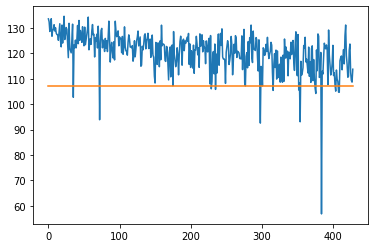

In [24]:
import matplotlib.pyplot as plt

plt.plot(np.arange(0, len(averages)), averages, label = 'Distances')
plt.plot(np.arange(0, len(averages)), np.repeat(y_filter_line, len(averages)), label = 'Sorting line')
plt.show()

# Creating new custom a3m file

In [26]:
fileName = config.get('testCases', testCaseName).split('/').pop()
customFileName = fileName.split('.')[0] + '.custom.' + fileName.split('.')[1]

with open(customFileName, 'w') as file:
  for i in range(len(sequences)):
    if(sequences[i].distance >= y_filter_line):
      file.write(sequences[i].name + '\n')
      file.write(sequences[i].seq + '\n')